## 1. Config

In [37]:
# Configures TensorFlow ops to run deterministically.

# !pip install --upgrade tensorflow==2.9.1
# !pip install tensorflow-gpu
!pip install tensorflow-determinism

import numpy as np
import tensorflow as tf
print("tensorflow version:", tf.__version__)
import random as python_random
import os


# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# tf.config.experimental.enable_op_determinism() # tf version should be 2.9

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

tensorflow version: 2.6.2


2022-08-14 15:26:07.015210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.016613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.017597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.018833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.019925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [38]:
# [feature]
channels = 10
fold = 10
epoch_f = 80
batch_size_f = 64
optimizer_f = "adam"
learn_rate_f = 0.0002

# [train]
channels = 10
fold = 10
context = 5
num_epochs = 80
batch_size = 128
optimizer = "adam"
learn_rate = 0.0002
lambda_GRL = 0.001

# [model]
adj_matrix = "fix"
dense_size = [64]
GLalpha = 0.0001
num_of_chev_filters = 64
num_of_time_filters = 64
time_conv_strides = 1
time_conv_kernel = 3
num_block = 1
cheb_k = 3
l1 = 0.001
l2 = 0.001
dropout = 0.5

Path = {
    "Save": "./",
    "disM": "../input/isruc-s3-preprocess/DistanceMatrix.npy",
    "data": "../input/isruc-s3-preprocess/ISRUC_S3.npz"
}

## 2. Read data and process data

In [39]:
import sys
sys.path.append('../input')

from isrucutitls.Utils import *
from isrucutitls.DataGenerator import *

In [40]:
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num   = ReadList['Fold_len']    # Num of samples of each fold
# Prepare Chebyshev polynomial of G_DC
Dis_Conn = np.load(Path['disM'], allow_pickle=True)  # shape:[V,V]
L_DC = scaled_Laplacian(Dis_Conn)                    # Calculate laplacian matrix
cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)         # K-order Chebyshev polynomial

print("Read data successfully")
Fold_Num_c  = Fold_Num + 1 - context
print('Number of samples: ',np.sum(Fold_Num), '(with context:', np.sum(Fold_Num_c), ')')
# Build kFoldGenerator or DominGenerator
Dom_Generator = DominGenerator(Fold_Num_c)

Read data successfully
Number of samples:  8589 (with context: 8549 )


In [41]:
Fold_Num

array([924, 911, 794, 764, 914, 823, 784, 970, 939, 766], dtype=int32)

## 3. Model training (cross validation)

### Model Structure

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout, Lambda
# from tensorflow.python.framework import ops
# tf.compat.v1.disable_eager_execution()
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

'''
Model code of MSTGCN.
--------
Model input:  (*, T, V, F)
    T: num_of_timesteps
    V: num_of_vertices
    F: num_of_features
Model output: (*, 5)
'''


################################################################################################
################################################################################################
# Attention Layers

class TemporalAttention(Layer):
    '''
    compute temporal attention scores
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_timesteps, num_of_timesteps)
    '''
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        _, num_of_timesteps, num_of_vertices, num_of_features = input_shape
        self.U_1 = self.add_weight(name='U_1',
                                   shape=(num_of_vertices, 1),
                                   initializer='uniform',
                                   trainable=True)
        self.U_2 = self.add_weight(name='U_2',
                                   shape=(num_of_features, num_of_vertices),
                                   initializer='uniform',
                                   trainable=True)
        self.U_3 = self.add_weight(name='U_3',
                                   shape=(num_of_features, ),
                                   initializer='uniform',
                                   trainable=True)
        self.b_e = self.add_weight(name='b_e',
                                   shape=(1, num_of_timesteps, num_of_timesteps),
                                   initializer='uniform',
                                   trainable=True)
        self.V_e = self.add_weight(name='V_e',
                                   shape=(num_of_timesteps, num_of_timesteps),
                                   initializer='uniform',
                                   trainable=True)
        super(TemporalAttention, self).build(input_shape)

    def call(self, x):
        _, T, V, F = x.shape

        # shape of lhs is (batch_size, V, T)
        lhs = K.dot(tf.transpose(x, perm=[0,1,3,2]), self.U_1)
        lhs = tf.reshape(lhs, [tf.shape(x)[0], T, F])
        lhs = K.dot(lhs, self.U_2)

        # shape of rhs is (batch_size, T, V)
        rhs = K.dot(self.U_3, tf.transpose(x,perm=[2,0,3,1]))
        rhs = tf.transpose(rhs, perm=[1,0,2])

        # shape of product is (batch_size, V, V)
        product = K.batch_dot(lhs, rhs)

        S = tf.transpose(K.dot(self.V_e, tf.transpose(K.sigmoid(product + self.b_e),perm=[1, 2, 0])),perm=[2, 0, 1])

        # normalization
        S = S - K.max(S, axis = 1, keepdims = True)
        exp = K.exp(S)
        S_normalized = exp / K.sum(exp, axis = 1, keepdims = True)
        return S_normalized

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[1])
    def get_config(self):
        config = super(TemporalAttention, self).get_config()
        return config
    
class SpatialAttention(Layer):
    '''
    compute spatial attention scores
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_vertices, num_of_vertices)
    '''
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        _, num_of_timesteps, num_of_vertices, num_of_features = input_shape
        self.W_1 = self.add_weight(name='W_1',
                                   shape=(num_of_timesteps, 1),
                                   initializer='uniform',
                                   trainable=True)
        self.W_2 = self.add_weight(name='W_2',
                                   shape=(num_of_features, num_of_timesteps),
                                   initializer='uniform',
                                   trainable=True)
        self.W_3 = self.add_weight(name='W_3',
                                   shape=(num_of_features, ),
                                   initializer='uniform',
                                   trainable=True)
        self.b_s = self.add_weight(name='b_s',
                                   shape=(1, num_of_vertices, num_of_vertices),
                                   initializer='uniform',
                                   trainable=True)
        self.V_s = self.add_weight(name='V_s',
                                   shape=(num_of_vertices, num_of_vertices),
                                   initializer='uniform',
                                   trainable=True)
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        _, T, V, F = x.shape

        # shape of lhs is (batch_size, V, T)
        lhs = K.dot(tf.transpose(x, perm=[0,2,3,1]), self.W_1) # (batch_size, V, F, T) * (T, 1) = (batch_size, V, F, 1)
        lhs = tf.reshape(lhs,[tf.shape(x)[0], V, F])  # (batch_size, V, F, 1) -> (batch_size, V, F)
        lhs = K.dot(lhs, self.W_2)  # (batch_size, V, F) * (F, T) = (batch_size, V, T)

        # shape of rhs is (batch_size, T, V)
        rhs = K.dot(self.W_3, tf.transpose(x, perm=[1,0,3,2]))  # (F, ) * (T, batch_size, F, V) = (T, batch_size, V)
        rhs = tf.transpose(rhs, perm=[1,0,2])

        # shape of product is (batch_size, V, V)
        product = K.batch_dot(lhs, rhs)

        S = tf.transpose(K.dot(self.V_s, tf.transpose(K.sigmoid(product + self.b_s),perm=[1, 2, 0])),perm=[2, 0, 1])

        # normalization
        S = S - K.max(S, axis = 1, keepdims = True)
        exp = K.exp(S)
        S_normalized = exp / K.sum(exp, axis = 1, keepdims = True)
        return S_normalized

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2], input_shape[2])
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        return config

################################################################################################
################################################################################################
# Adaptive Graph Learning Layer

def diff_loss(diff, S):
    '''
    compute the 1st loss of L_{graph_learning}
    '''
    if len(S.shape) == 4:
        # batch input
        return K.mean(K.sum(K.sum(diff**2, axis=3) * S, axis=(1, 2)))
    else:
        return K.sum(K.sum(diff**2, axis=2) * S)


def F_norm_loss(S, Falpha):
    '''
    compute the 2nd loss of L_{graph_learning}
    '''
    if len(S.shape) == 4:
        # batch input
        return Falpha * K.sum(K.mean(S**2, axis=0))
    else:
        return Falpha * K.sum(S**2)


class Graph_Learn(Layer):
    '''
    Graph structure learning (based on the middle time slice)
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_vertices, num_of_vertices)
    '''
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        self.S = tf.convert_to_tensor([[[0.0]]])  # similar to placeholder
        self.diff = tf.convert_to_tensor([[[[0.0]]]])  # similar to placeholder
        super(Graph_Learn, self).__init__(**kwargs)

    def build(self, input_shape):
        _, num_of_timesteps, num_of_vertices, num_of_features = input_shape
        self.a = self.add_weight(name='a',
                                 shape=(num_of_features, 1),
                                 initializer='uniform',
                                 trainable=True)
        # add loss L_{graph_learning} in the layer
        self.add_loss(F_norm_loss(self.S, self.alpha))
        self.add_loss(diff_loss(self.diff, self.S))
        super(Graph_Learn, self).build(input_shape)

    def call(self, x):
        _, T, V, F = x.shape
        N = tf.shape(x)[0]

        outputs = []
        diff_tmp = 0
        for time_step in range(T):
            # shape: (N,V,F) use the current slice
            xt = x[:, time_step, :, :]
            # shape: (N,V,V)
            diff = tf.transpose(tf.broadcast_to(xt, [V,N,V,F]), perm=[2,1,0,3]) - xt
            # shape: (N,V,V)
            tmpS = K.exp(K.reshape(K.dot(tf.transpose(K.abs(diff), perm=[1,0,2,3]), self.a), [N,V,V]))
            # normalization
            S = tmpS / tf.transpose(tf.broadcast_to(K.sum(tmpS, axis=1), [V,N,V]), perm=[1,2,0])

            diff_tmp += K.abs(diff)
            outputs.append(S)

        outputs = tf.transpose(outputs, perm=[1,0,2,3])
        self.S = K.mean(outputs, axis=0)
        self.diff = K.mean(diff_tmp, axis=0) /tf.convert_to_tensor(int(T), tf.float32)
        return outputs

    def compute_output_shape(self, input_shape):
        # shape: (n, num_of_vertices,num_of_vertices, num_of_vertices)
        return (input_shape[0],input_shape[1],input_shape[2],input_shape[2])
    def get_config(self):
        config = {'alpha': self.alpha, 'S': self.S, 'diff': self.diff}
        base_config = super(Graph_Learn, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


################################################################################################
################################################################################################
# GCN layers

class cheb_conv_with_Att_GL(Layer):
    '''
    K-order chebyshev graph convolution with attention after Graph Learn
    --------
    Input:  [x   (batch_size, num_of_timesteps, num_of_vertices, num_of_features),
             Att (batch_size, num_of_vertices, num_of_vertices),
             S   (batch_size, num_of_vertices, num_of_vertices)]
    Output: (batch_size, num_of_timesteps, num_of_vertices, num_of_filters)
    '''
    def __init__(self, num_of_filters, k, **kwargs):
        self.k = k
        self.num_of_filters = num_of_filters
        super(cheb_conv_with_Att_GL, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        x_shape, Att_shape, S_shape = input_shape
        _, T, V, F = x_shape
        self.Theta = self.add_weight(name='Theta',
                                     shape=(self.k, F, self.num_of_filters),
                                     initializer='uniform',
                                     trainable=True)
        super(cheb_conv_with_Att_GL, self).build(input_shape)

    def call(self, x):
        #Input:  [x, Att, S]
        assert isinstance(x, list)
        assert len(x)==3, 'Cheb_gcn input error'
        x, Att, S = x
        _, T, V, F = x.shape

        S = K.minimum(S, tf.transpose(S,perm=[0,1,3,2])) # Ensure symmetry

        # GCN
        outputs=[]
        for time_step in range(T):
            # shape of x is (batch_size, V, F)
            graph_signal = x[:, time_step, :, :]
            output = tf.zeros(shape=(tf.shape(x)[0], V, self.num_of_filters))

            A = S[:, time_step, :, :]
            #Calculating Chebyshev polynomials (let lambda_max=2)
            D = tf.compat.v1.matrix_diag(K.sum(A, axis=1))
            L = D - A
            L_t = L - [tf.eye(int(V))]
            cheb_polynomials = [tf.eye(int(V)), L_t]
            for i in range(2, self.k):
                cheb_polynomials.append(2 * L_t * cheb_polynomials[i - 1] - cheb_polynomials[i - 2])

            for kk in range(self.k):
                T_k = cheb_polynomials[kk]              # shape of T_k is (V, V)
                T_k_with_at = T_k * Att                 # shape of T_k_with_at is (batch_size, V, V)
                theta_k = self.Theta[kk]                # shape of theta_k is (F, num_of_filters)

                # shape is (batch_size, V, F)
                rhs = K.batch_dot(tf.transpose(T_k_with_at, perm=[0, 2, 1]), graph_signal)
                output = output + K.dot(rhs, theta_k)
            outputs.append(tf.expand_dims(output,-1))

        return tf.transpose(K.relu(K.concatenate(outputs, axis=-1)), perm=[0,3,1,2])

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        # shape: (n, num_of_timesteps, num_of_vertices, num_of_filters)
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2], self.num_of_filters)
    def get_config(self):
        config = {'num_of_filters': self.num_of_filters, 'k': self.k}
        base_config = super(cheb_conv_with_Att_GL, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class cheb_conv_with_Att_static(Layer):
    '''
    K-order chebyshev graph convolution with static graph structure
    --------
    Input:  [x   (batch_size, num_of_timesteps, num_of_vertices, num_of_features),
             Att (batch_size, num_of_vertices, num_of_vertices)]
    Output: (batch_size, num_of_timesteps, num_of_vertices, num_of_filters)
    '''
    def __init__(self, num_of_filters, k, cheb_polynomials, **kwargs):
        self.k = k
        self.num_of_filters = num_of_filters
        self.cheb_polynomials = tf.compat.v1.to_float(np.array(cheb_polynomials))
        super(cheb_conv_with_Att_static, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        x_shape, Att_shape = input_shape
        _, T, V, F = x_shape
        self.Theta = self.add_weight(name='Theta',
                                     shape=(self.k, F, self.num_of_filters),
                                     initializer='uniform',
                                     trainable=True)
        super(cheb_conv_with_Att_static, self).build(input_shape)

    def call(self, x):
        #Input:  [x, Att]
        assert isinstance(x, list)
        assert len(x) == 2, 'cheb_gcn error'
        x, Att = x
        _, T, V, F = x.shape

        outputs = []
        for time_step in range(T):
            # shape is (batch_size, V, F)
            graph_signal = x[:, time_step, :, :]
            output = tf.zeros(shape=(tf.shape(x)[0], V, self.num_of_filters))

            for kk in range(self.k):
                T_k = self.cheb_polynomials[kk]          # shape of T_k is (V, V) 
                T_k_with_at = T_k * Att  # shape of T_k_with_at is (batch_size, V, V)
                T_k_with_at = keras.layers.Dropout(0.6)(T_k_with_at)
                theta_k = self.Theta[kk]                 # shape of theta_k is (F, num_of_filters)

                # shape is (batch_size, V, F)
                rhs = K.batch_dot(tf.transpose(T_k_with_at, perm=[0, 2, 1]), graph_signal)
                output = output + K.dot(rhs, theta_k)
            outputs.append(tf.expand_dims(output, -1))

        return tf.transpose(K.relu(K.concatenate(outputs, axis=-1)), perm=[0, 3, 1, 2])

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        # shape: (n, num_of_timesteps, num_of_vertices, num_of_filters)
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2], self.num_of_filters)
    def get_config(self):
        config = {'num_of_filters': self.num_of_filters, 'k': self.k, 'cheb_polynomials': self.cheb_polynomials}
        base_config = super(cheb_conv_with_Att_static, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

################################################################################################
################################################################################################
# Some operations

def reshape_dot(x):
    #Input:  [x,TAtt]
    x, TAtt = x
    return tf.reshape(
        K.batch_dot(
            tf.reshape(tf.transpose(x, perm=[0, 2, 3, 1]),
                       (tf.shape(x)[0], -1, tf.shape(x)[1])), TAtt),
        [-1, x.shape[1], x.shape[2], x.shape[3]]
    )
def reshape_spatio_dot(x):
    #Input:  [x,TAtt]
    x, TAtt = x
    return tf.reshape(
            K.batch_dot(
                tf.reshape(tf.transpose(x, perm=[0, 1, 3, 2]),
                           (tf.shape(x)[0], -1, tf.shape(x)[2])), TAtt),
            [-1, x.shape[1], x.shape[2], x.shape[3]]
        )
class ReshapeSpatioDot(Layer):
    def __init__(self, **kwargs):
        super(ReshapeDot, self).__init__(**kwargs)
    def call(self, x, **kwargs):
        x, TAtt = x
        return tf.reshape(
            K.batch_dot(
                tf.reshape(tf.transpose(x, perm=[0, 1, 3, 2]),
                           (tf.shape(x)[0], -1, tf.shape(x)[2])), TAtt),
            [-1, x.shape[1], x.shape[2], x.shape[3]]
        )
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2], input_shape[0][3])
    def get_config(self):
        config = super(ReshapeDot, self).get_config()
        return config

class LayerNorm(Layer):
    def __init__(self, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)

    def call(self, x):
        relu_x = K.relu(x)
        return layers.LayerNormalization(3)(relu_x)

    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        config = {}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


################################################################################################
################################################################################################
# Gradient Reverse Layer
class GradientReversal(keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    @tf.custom_gradient
    def grad_reverse(self, x):
        y = tf.identity(x)
        def custom_grad(dy):
            return -self.hp_lambda * dy
        return y, custom_grad

    # --------------------------------------
    def __init__(self, hp_lambda=0.001, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.hp_lambda = K.variable(hp_lambda, dtype='float32', name='hp_lambda')

    # --------------------------------------
    def call(self, x, mask=None):
        return self.grad_reverse(x)

    # --------------------------------------
    def set_hp_lambda(self,hp_lambda):
        #self.hp_lambda = hp_lambda
        K.set_value(self.hp_lambda, hp_lambda)

    # --------------------------------------
    def increment_hp_lambda_by(self,increment):
        new_value = float(K.get_value(self.hp_lambda)) +  increment
        K.set_value(self.hp_lambda, new_value)

    def get_hp_lambda(self):
        return float(K.get_value(self.hp_lambda))
    def get_config(self):
        config = {}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

################################################################################################
################################################################################################
# MSTGCN Block
class SpatioTemporalAttention(layers.Layer):
    '''
    compute the mix spatio-temporal attention socres
    --------
    Input: (batch_size, num_of_timesteps, num_of_channels, features)
    Output:
    value: (batch_size, num_of_timesteps, num_of_channels, features)
    att: (batch_size, num_of_timesteps, num_of_channels)
    '''

    def __init__(self, **kwargs):
        super(SpatioTemporalAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        bs, num_of_timesteps, num_of_channels, features = input_shape
        self.W_q = self.add_weight(name='W_q', shape=(features, features),
                                   initializer='uniform', trainable=True)
        self.W_k = self.add_weight(name='W_k', shape=(features, features),
                                   initializer='uniform', trainable=True)
        self.W_v = self.add_weight(name='W_v', shape=(features, features),
                                   initializer='uniform', trainable=True)
        self.W_o = self.add_weight(name='W_o', shape=(features, features),
                                   initializer='uniform', trainable=True)
        self.W_p = self.add_weight(name='W_p', shape=(num_of_channels, num_of_timesteps),
                                   initializer='uniform', trainable=True)
        self.W_s = self.add_weight(name='W_s', shape=(num_of_timesteps, num_of_channels),
                                   initializer='uniform', trainable=True)
        self.u_t = self.add_weight(name='u_t', shape=(num_of_timesteps,),
                                   initializer='uniform', trainable=True)
        self.u_s = self.add_weight(name='u_s', shape=(num_of_channels,),
                                   initializer='uniform', trainable=True)
        self.b_s = self.add_weight(name='b_s', shape=(1, num_of_timesteps, num_of_channels),
                                   initializer='uniform', trainable=True)
        super(SpatioTemporalAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bs, T, S, F = inputs.shape
        # (bs, T, F) x (F, dim) = (bs, T, dim)
        q = K.dot(K.dot(self.u_s, inputs), self.W_q)
        # (bs, S, F) x (F, dim) = (bs, S, dim)
        k = K.dot(K.dot(self.u_t, tf.transpose(inputs, perm=[0, 2, 1, 3])), self.W_k)
        # (bs, T, S, F) x (F, dim) = (bs, T, S, dim)
        v = K.dot(inputs, self.W_v)

        # compute spatio-temporal attention matrix: (bs, T, S)
        score = K.batch_dot(q, tf.transpose(k, perm=[0, 2, 1])) / K.sqrt(tf.cast(tf.shape(q)[-1], dtype=tf.float32))
        # score = tf.reshape(K.softmax(K.flatten(att)), (bs, T, S))
        score = K.sigmoid(score)  # sigmoid is better

        # (bs, T, S) x (S, T) = (bs, T, T)
        P = self._normalization(K.dot(score, self.W_p))
        # (bs, T, S) x (T, S) = (bs, S, S)
        S = self._normalization(K.dot(tf.transpose(score, perm=[0,2,1]), self.W_s))

        # linear combination: (bs, T, S, dim) * (bs, T, S) = (bs, T, S, dim)
#         o = tf.transpose(tf.multiply(tf.transpose(v, perm=[3, 0, 1, 2]), score), perm=[1, 2, 3, 0])
        o = K.tanh(K.dot(tf.transpose(
            tf.multiply(tf.transpose(v, perm=[3, 0, 1, 2]), score), perm=[1, 2, 3, 0]),
            self.W_o
        ))
#         o = tf.transpose(
#             K.batch_dot( # (bs, F, T, S) x (bs, S, S)
#                 tf.transpose( # (bs, F, T, S)
#                     K.batch_dot( # (bs, F, S, T)
#                         tf.transpose(K.dot(v, self.W_o), perm=[0, 3, 2, 1]), P
#                     ), perm=[0,1,3,2]),
#                 S),
#             perm=[0,2,3,1])
#         o = tf.transpose( # (bs, T, S, F)
#                     K.batch_dot( # (bs, F, S, T)
#                         tf.transpose(K.dot(v, self.W_o), perm=[0, 3, 2, 1]), P
#                     ), perm=[0,3,2,1])

        # (bs, T, S, F) x (bs, T, T) = (bs, T, S, F)
        o_p = tf.transpose(K.batch_dot(
            tf.transpose(K.dot(v, self.W_o), perm=[0, 3, 2, 1]),
            P), perm=[0, 3, 2, 1]
        )
        # (bs, T, S, F) x (bs, S, S) = (bs, T, S, F)
        o_s = tf.transpose(K.batch_dot(
            tf.transpose(K.dot(v, self.W_o), perm=[0, 1, 3, 2]),
            S), perm=[0, 1, 3, 2]
        )
        return o, o_p, o_s, score, P, S
    def _normalization(self, S): # (bs, T, T) or (bs, S, S)
        S = S - K.max(S, axis=1, keepdims=True)
        exp = K.exp(S)
        S_normalized = exp / K.sum(exp, axis=1, keepdims=True)
        return S_normalized
    def compute_output_shape(self, input_shape):
        return input_shape

def MSTGCN_Block(x, k, num_of_chev_filters, num_of_time_filters, time_conv_strides,
                 cheb_polynomials, time_conv_kernel, GLalpha, i=0):
    '''
    packaged Spatial-temporal convolution Block
    -------
    x: input data;
    k: k-order cheb GCN
    i: block number
    '''
    # use spatio-temporal attention
    x, o_p, o_s, score, temporal_Att, spatial_Att = SpatioTemporalAttention()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
#     # temporal attention
#     temporal_Att = TemporalAttention()(x)
#     x_TAtt = reshape_dot([x, temporal_Att])

#     # spatial attention
#     spatial_Att = SpatialAttention()(x_TAtt)
#     x = reshape_spatio_dot([x_TAtt, spatial_Att])
    
    # multi-view GCN
    S = Graph_Learn(alpha=GLalpha)(x)
    S = Dropout(0.3)(S)
    
    spatial_gcn_GL = cheb_conv_with_Att_GL(num_of_filters=num_of_chev_filters, k=k)([x, spatial_Att, S])
    spatial_gcn_SD = cheb_conv_with_Att_static(num_of_filters=num_of_chev_filters, k=k,
                                               cheb_polynomials=cheb_polynomials)([x, spatial_Att])

    
#     spatial_gcn_GL = x_TAtt
    # temporal convolution
#     spatial_gcn_GL, o_p, o_s, score, temporal_Att, spatial_Att = SpatioTemporalAttention()(spatial_gcn_GL)
    time_conv_output_GL = layers.Conv2D(
        filters=num_of_time_filters,
        kernel_size=(time_conv_kernel, 1),
        padding='same',
        strides=(1, time_conv_strides),
        activation='relu'
    )(spatial_gcn_GL)
    
#     spatial_gcn_SD, o_p, o_s, score, temporal_Att, spatial_Att = SpatioTemporalAttention()(spatial_gcn_SD)
    time_conv_output_SD = layers.Conv2D(
        filters=num_of_time_filters,
        kernel_size=(time_conv_kernel, 1),
        padding='same',
        strides=(1, time_conv_strides),
        activation='relu'
    )(spatial_gcn_SD)

    # LayerNorm
#     end_output_GL = Lambda(LayerNorm, name='layer_norm' + str(2*i))(time_conv_output_GL)
    end_output_GL = tf.keras.layers.LayerNormalization(axis=3)(time_conv_output_GL)
#     end_output_SD = Lambda(LayerNorm, name='layer_norm' + str(2*i+1))(time_conv_output_SD)
    end_output_SD = tf.keras.layers.LayerNormalization(axis=3)(time_conv_output_SD)
    return end_output_GL, end_output_SD

################################################################################################
################################################################################################
# MSTGCN

def build_MSTGCN(k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_polynomials,
                 time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha,
                 regularizer, dropout, lambda_reversal=1, num_classes=5, num_domain=9, useGL=True):

    # Input:  (*, num_of_timesteps, num_of_vertices, num_of_features)
    data_layer = layers.Input(shape=sample_shape, name='Input_Layer')

    # MSTGCN_Block
    block_out_GL, block_out_SD = MSTGCN_Block(data_layer, k, num_of_chev_filters, num_of_time_filters,
                                              time_conv_strides, cheb_polynomials, time_conv_kernel, GLalpha)
    for i in range(1, num_block):
        block_out_GL, block_out_SD = MSTGCN_Block(block_out_GL, k, num_of_chev_filters, num_of_time_filters,
                                                  time_conv_strides, cheb_polynomials, time_conv_kernel, GLalpha, i)
    block_out = layers.concatenate([block_out_GL, block_out_SD])
    block_out = layers.Flatten()(block_out)
#     block_out = layers.GlobalAveragePooling2D()(block_out)

    # dropout
    if dropout != 0:
        block_out = layers.Dropout(dropout)(block_out)
    block_out = layers.Dense(128)(block_out) # use for future contrastive learning
    
        
    model_cl = models.Model(inputs=data_layer, outputs=block_out) # contrastive learning
    model_cl.compile(
        optimizer=opt,
        loss=multi_label_supconloss,
    )
    
    # Global dense layer # original code have bug here （without assignment）
    for size in dense_size:
#         dense_out = layers.Dense(size)(block_out)
        dense_out = block_out # add dense layer performance decline

    # softmax classification
    softmax = layers.Dense(num_classes,
                           activation='softmax',
                           kernel_regularizer=regularizer,
                           name='Label')(dense_out)

    # GRL & G_d
    flip_layer = GradientReversal(lambda_reversal)
    G_d_in = flip_layer(block_out)
    for size in dense_size:
#         G_d_out = layers.Dense(size)(G_d_in)
        G_d_out = G_d_in
    G_d_out = layers.Dense(units=num_domain,
                           activation='softmax',
                           name='Domain')(G_d_out)

    # training model (with GRL & G_d)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    model = models.Model(inputs=data_layer, outputs=[softmax, G_d_out])
    model.compile(
        optimizer=opt,
        loss={'Label': "categorical_crossentropy", 'Domain': "categorical_crossentropy"}, 
        metrics={'Label': "acc", 'Domain': "acc"}, 
        loss_weights=[1,0.2]
    )
    # testing model (without GRL & G_d)
    pre_model = models.Model(inputs=data_layer, outputs=softmax)
    pre_model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    return model, pre_model, model_cl
#     return pre_model


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18290610620782599724
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1045382841930850755
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Number of devices: 1


2022-08-14 15:26:07.224964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.226031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.226912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.227822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 15:26:07.228796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [44]:
def build_MSTGCN_test():
    # an example to test
    cheb_k = 3
    num_of_chev_filters = 64
    num_of_time_filters = 64
    time_conv_strides = 1
    time_conv_kernel = 3
    dense_size = np.array([64, 32])
    cheb_polynomials = [np.random.rand(10, 10), np.random.rand(10, 10), np.random.rand(10, 10)]
    sample_shape = (5,10,256)
    # Instantiation optimizer
    opt = Instantiation_optim(optimizer, learn_rate)
    # Instantiation l1, l2 regularizer
    regularizer = Instantiation_regularizer(l1, l2)
    model, p_model, model_cl = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
                                  time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
                                  dropout, lambda_GRL, num_classes=5, num_domain=9)
    model.summary()
    p_model.summary()
    model_cl.summary()
    return model
build_MSTGCN_test()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 5, 10, 256)] 0                                            
__________________________________________________________________________________________________
spatio_temporal_attention_11 (S ((None, 5, 10, 256), 262309      Input_Layer[0][0]                
__________________________________________________________________________________________________
layer_normalization_10 (LayerNo (None, 5, 10, 256)   512         spatio_temporal_attention_11[0][0
__________________________________________________________________________________________________
graph__learn_5 (Graph_Learn)    (None, 5, 10, 10)    256         layer_normalization_10[0][0]     
___________________________________________________________________________________________

## Train model

In [45]:
import gc
from sklearn import metrics
import pickle
feature_path = "../input/fork-of-isruc-s3-resnet-cl-domain-all-data"
# k-fold cross validation
all_scores = []
AllPred, AllTrue = None, None

for i in range(0, fold):
    print(128*'_')
    print('Fold #', i)

    # Instantiation optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    # Instantiation l1, l2 regularizer
    regularizer = Instantiation_regularizer(l1, l2)

    # get i th-fold feature and label
    Features = np.load(feature_path +'/Feature_'+str(i)+'.npz', allow_pickle=True)
    train_feature = Features['train_feature']
    val_feature   = Features['val_feature']
    train_targets = Features['train_targets']
    val_targets   = Features['val_targets']
    
    ## Use the feature to train MSTGCN
    print('Feature',train_feature.shape,val_feature.shape)
    train_feature, train_targets  = AddContext_MultiSub(train_feature, train_targets,
                                                        np.delete(Fold_Num.copy(), i), context, i)
    val_feature, val_targets      = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)
    sample_shape = (val_feature.shape[1:])
    print('Feature with context:',train_feature.shape, val_feature.shape)
    model, model_p, model_cl = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
                                  time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
                                  dropout, lambda_GRL, num_classes=5, num_domain=9) # '_p' model is without GRL
    
#     print("*"*30 + "Contrastive Learning" + "*"*30)
#     history = model_cl.fit(train_feature, train_targets, 
#         batch_size=batch_size, epochs=10, validation_data=(val_feature, val_targets),
#         callbacks=[keras.callbacks.ModelCheckpoint(Path['Save']+'CL_Best_'+str(i)+'.h5', 
#                                                    monitor='val_loss', 
#                                                    verbose=0, 
#                                                    save_best_only=True, 
#                                                    save_weights_only=True, 
#                                                    mode='min', 
#                                                    period=1 )]
#     )
#     model_cl.load_weights(Path['Save']+'CL_Best_'+str(i)+'.h5')
    
#     saveFile = open(Path['Save'] + "train_cl_model_HistoryDict.txt", 'a+')
#     print('Fold #'+str(i), file=saveFile)
#     print(history.history, file=saveFile)
#     saveFile.close()
    
    print("*"*30 + "Cross Entropy Training" + "*"*30)
    train_y = [train_targets,train_domin]
    val_y = [val_targets,val_domin]
    verbose = 0
    if i == 0:
        model.summary()
        verbose = 1
#     num_epochs = 1
    history = model.fit(
        x = train_feature,
        y = train_y,
        epochs = num_epochs,
        batch_size = batch_size,
        shuffle = False,
        validation_data = (val_feature, val_y),
        verbose = verbose,
        callbacks=[keras.callbacks.ModelCheckpoint(Path['Save']+'MSTGCN_Best_'+str(i)+'.h5', 
                                                   monitor='val_Label_acc', 
                                                   verbose=0, 
                                                   save_best_only=True, 
                                                   save_weights_only=True, 
                                                   mode='max', 
                                                   period=1 )]
        )
    # save the final model
    model.save_weights(Path['Save']+'MSTGCN_Final_'+str(i)+'.h5')

    # Save training information
    if i==0:
        fit_loss = np.array(history.history['loss'])*Fold_Num_c[i]
        fit_acc = np.array(history.history['Label_acc'])*Fold_Num_c[i]
        fit_val_loss = np.array(history.history['val_loss'])*Fold_Num_c[i]
        fit_val_acc = np.array(history.history['val_Label_acc'])*Fold_Num_c[i]
    else:
        fit_loss = fit_loss+np.array(history.history['loss'])*Fold_Num_c[i]
        fit_acc = fit_acc+np.array(history.history['Label_acc'])*Fold_Num_c[i]
        fit_val_loss = fit_val_loss+np.array(history.history['val_loss'])*Fold_Num_c[i]
        fit_val_acc = fit_val_acc+np.array(history.history['val_Label_acc'])*Fold_Num_c[i]

    model.load_weights(Path['Save']+'MSTGCN_Best_'+str(i)+'.h5')

    print("Best score:", max(history.history['val_Label_acc']))
    all_scores.append(max(history.history['val_Label_acc']))
    saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
    print('Fold #'+str(i), file=saveFile)
    print(history.history, file=saveFile)
    saveFile.close()

    # Predict ------------------------------------------------------------
    predicts, _ = model.predict(val_feature, batch_size=batch_size)
    AllPred_temp = np.argmax(predicts, axis=1)
    AllTrue_temp = np.argmax(val_targets, axis=1)
    print("Predict accuracy:", metrics.accuracy_score(AllTrue_temp, AllPred_temp))
    if i == 0:
        AllPred = AllPred_temp
        AllTrue = AllTrue_temp
    else:
        AllPred = np.concatenate((AllPred, AllPred_temp))
        AllTrue = np.concatenate((AllTrue, AllTrue_temp))
    # 发现如果在下一个代码块中 evaluate，结果不一致（一般是变差）
    val_mse, val_acc = model_p.evaluate(val_feature, val_targets, verbose=0)

    # Evaluate check model can recurrence -------------------------------
    print('Evaluate', val_acc)
    if val_acc < max(history.history['val_Label_acc']):
        print("Evaluate performance is lower than train: ", max(history.history['val_Label_acc']))
        val_acc = max(history.history['val_Label_acc'])
    # Fold finish
    keras.backend.clear_session()
    del model, model_p, train_feature, train_targets, val_feature, val_targets
    gc.collect()

________________________________________________________________________________________________________________________________
Fold # 0
Feature (7665, 10, 128) (924, 10, 128)
Feature with context: (7629, 5, 10, 128) (920, 5, 10, 128)
******************************Cross Entropy Training******************************
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 5, 10, 128)] 0                                            
__________________________________________________________________________________________________
spatio_temporal_attention_12 (S ((None, 5, 10, 128), 65701       Input_Layer[0][0]                
__________________________________________________________________________________________________
layer_normalization_13 (LayerNo (None, 5, 10, 128)   256         spat

# 4. Final results

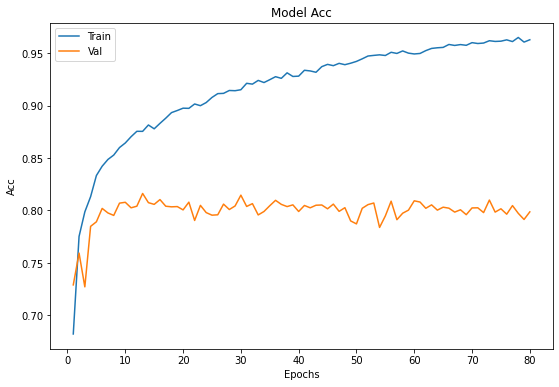

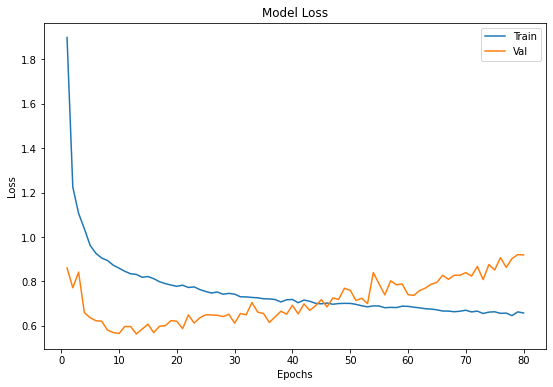

________________________________________________________________________________________________________________________________
End of training MSTGCN.
################################################################################################################################


In [46]:
# Average training performance
fit_acc      = fit_acc/np.sum(Fold_Num_c)
fit_loss     = fit_loss/np.sum(Fold_Num_c)
fit_val_loss = fit_val_loss/np.sum(Fold_Num_c)
fit_val_acc  = fit_val_acc/np.sum(Fold_Num_c)

# Draw ACC / loss curve and save
VariationCurve(fit_acc, fit_val_acc, 'Acc', Path['Save'], figsize=(9, 6))
VariationCurve(fit_loss, fit_val_loss, 'Loss', Path['Save'], figsize=(9, 6))

saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
print(history.history, file=saveFile)
saveFile.close()

print(128 * '_')
print('End of training MSTGCN.')
print(128 * '#')


All folds' acc:  [0.873913049697876, 0.8379272222518921, 0.8645569682121277, 0.7789473533630371, 0.8516483306884766, 0.8327228426933289, 0.8641025424003601, 0.9047619104385376, 0.8032085299491882, 0.808398962020874]
Average acc of each fold:  0.8420187711715699
Main scores:
Acc	F1S	Kappa	F1_W	F1_N1	F1_N2	F1_N3	F1_R
0.8435	0.8356	0.7987	0.9072	0.6630	0.8317	0.8945	0.8814

Classification report:
              precision    recall  f1-score   support

        Wake     0.9023    0.9122    0.9072      1651
          N1     0.6799    0.6469    0.6630      1215
          N2     0.8095    0.8551    0.8317      2609
          N3     0.9312    0.8605    0.8945      2014
         REM     0.8627    0.9009    0.8814      1060

    accuracy                         0.8435      8549
   macro avg     0.8371    0.8351    0.8356      8549
weighted avg     0.8443    0.8435    0.8433      8549

Confusion matrix:
[[1506  111   26    3    5]
 [ 121  786  202    0  106]
 [  31  188 2231  124   35]
 [   3    1 

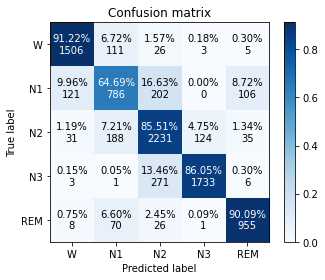

End of evaluating MSTGCN.
################################################################################################################################


In [47]:
# print acc of each fold
print(128*'=')
print("All folds' acc: ",all_scores)
print("Average acc of each fold: ",np.mean(all_scores))

# Print score to console
print(128*'=')
PrintScore(AllTrue, AllPred)
# Print score to Result.txt file
PrintScore(AllTrue, AllPred, savePath="./")

# Print confusion matrix and save
ConfusionMatrix(AllTrue, AllPred, classes=['W','N1','N2','N3','REM'], savePath="./")

print('End of evaluating MSTGCN.')
print(128 * '#')